整个 BM 算法步骤描述如下：

1. 计算出文本串 $T$ 的长度为 $n$，模式串 $p$ 的长度为 $m$。
2. 先对模式串 $p$ 进行预处理，生成坏字符位置表 $bc\underline{\hspace{0.5em}}table$ 和好后缀规则后移位数表 $gs\underline{\hspace{0.5em}}talbe$。
3. 将模式串 $p$ 的头部与文本串 $T$ 对齐，将 $i$ 指向文本串开始位置，即 $i = 0$。$j$ 指向模式串末尾位置，即 $j = m - 1$，然后从模式串末尾位置开始进行逐位比较。
   1. 如果文本串对应位置 $T[i + j]$ 上的字符与 $p[j]$ 相同，则继续比较前一位字符。
      1. 如果模式串全部匹配完毕，则返回模式串 $p$ 在文本串中的开始位置 $i$。
   2. 如果文本串对应位置 $T[i + j]$ 上的字符与 $p[j]$ 不相同，则：
      1. 根据坏字符位置表计算出在「坏字符规则」下的移动距离 $bad\underline{\hspace{0.5em}}move$。
      2. 根据好后缀规则后移位数表计算出在「好后缀规则」下的移动距离 $good\underline{\hspace{0.5em}}mode$。
      3. 取两种移动距离的最大值，然后对模式串进行移动，即 $i += max(bad\underline{\hspace{0.5em}}move, good\underline{\hspace{0.5em}}move)$。
4. 如果移动到末尾也没有找到匹配情况，则返回 $-1$。

- 坏字符规则
  
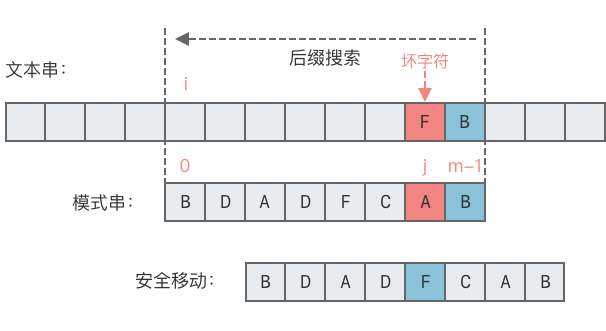

In [2]:
# 生成坏字符规则
def BCrule(c: str)-> dict:
    # 坏字符就是将模式字符串中的最后出现的字符位置记录下来
    # 在匹配中，如果存在不相等的情况，那么将模式字符串移动到最右边相匹配的位置上
    # 移动的位数是当前匹配到的模式串位置 - 最右边出现的位置（如果没有则为-1）
    size = len(c)
    table = {}
    # 遍历一遍，后出现的会将先出现的位置覆盖掉
    for i in range(size):
        table[c[i]] = i
    return table

string = "bdadfcab"
bcTable = BCrule(string)
bcTable

{'b': 7, 'd': 3, 'a': 6, 'f': 4, 'c': 5}

- 好后缀原则：
  - 如果当前判断不相等之前有后缀是匹配的，这个后缀就叫做好后缀
  - 如果模式串前缀此时有和后缀相等的部分，那么就可将当前的模式串的前缀移动到后缀相等的地方



In [15]:
# 和KMP算法类似，需要先生成一个类似的子串与最长后缀相等长度的数组

# 重点：   suffix[i] 表示为以下标 i 为结尾的子串与模式串后缀匹配的最大长度（结尾说明取得是前面的子串）
def generateSuffixArray(p: str):
    m = len(p)
    # 初始化时假设匹配的最大长度为 m
    suffix = [m for _ in range(m)]
    # 子串末尾从 m - 2 开始                  
    for i in range(m - 2, -1, -1):                  
        start = i # start 为子串开始位置
        while start >= 0 and p[start] == p[m - 1 - i + start]: # 后面的是后缀向前走
            start -= 1                              
        suffix[i] = i - start # 更新以下标 i 为结尾的子串与模式串后缀匹配的最大长度
    return suffix

string = "ABCDEFGBCDE"
a = generateSuffixArray(string)
a

[0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 11]

有了suffix数组就能求得向右移动的距离了
好后缀规则的移动方式可以分为三种情况。

- 情况 1：模式串中有子串匹配上好后缀。
- 情况 2：模式串中无子串匹配上好后缀，但有最长前缀匹配好后缀的后缀。
- 情况 3：模式串中无子串匹配上好后缀，也找不到前缀匹配。
情况3可以看成是前缀长度为0 的情况2
如果遇到多个情况， 我们应该选择移动长度最小的情况来避免漏掉匹配的情况


In [19]:
# 生成好后缀规则后移位数表

# 重点：   suffix[i] 表示为以下标 i 为结尾的子串与模式串后缀匹配的最大长度（结尾说明取得是前面的子串）
def generateSuffixArray(p: str):
    m = len(p)
    # 初始化时假设匹配的最大长度为 m
    suffix = [m for _ in range(m)]
    # 子串末尾从 m - 2 开始                  
    for i in range(m - 2, -1, -1):                  
        start = i # start 为子串开始位置
        while start >= 0 and p[start] == p[m - 1 - i + start]: # 后面的是后缀向前走
            start -= 1                              
        suffix[i] = i - start # 更新以下标 i 为结尾的子串与模式串后缀匹配的最大长度
    return suffix
# gs_list[j] 表示在 j 下标处遇到坏字符时，可根据好规则向右移动的距离


def generageGoodSuffixList(p: str):
    # 好后缀规则后移位数表
    # 情况 1: 模式串中有子串匹配上好后缀
    # 情况 2: 模式串中无子串匹配上好后缀，但有最长前缀匹配好后缀的后缀
    # 情况 3: 模式串中无子串匹配上好后缀，也找不到前缀匹配
    
    m = len(p)
    gs_list = [m for _ in range(m)]                 # 情况 3：初始化时假设全部为情况 3
    suffix = generateSuffixArray(p)                 # 生成 suffix 数组
    
    j = 0                                           # j 为好后缀前的坏字符位置
    for i in range(m - 1, -1, -1):                  # 情况 2：从最长的前缀开始检索
        if suffix[i] == i + 1:# 也只有suffix[i] == i + 1是前面最长子串也即是前缀   # 匹配到前缀，即 p[0...i] == p[m-1-i...m-1]
            while j < m - 1 - i:
                if gs_list[j] == m:
                    gs_list[j] = m - 1 - i# 都是一样的，只是遇到的位置不一样# 更新在 j 处遇到坏字符可向后移动位数
                j += 1
        
    for i in range(m - 1):                          # 情况 1：匹配到子串， p[i-s...i] == p[m-1-s, m-1]
        # 更新在好后缀的左端点处（m - 1 - suffix[i] 处）遇到坏字符可向后移动位数
        gs_list[m - 1 - suffix[i]] = m - 1 - i      # 更新在好后缀的左端点处遇到坏字符可向后移动位数
    return gs_list

string = "ABCDEFGBCDE"
a = generageGoodSuffixList(string)
a
# suffix [0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 11]
# 不算情况三gs_list[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
# 算上情况三：[11, 11, 11, 11, 11, 11, 6, 11, 11, 11, 1]

[11, 11, 11, 11, 11, 11, 6, 11, 11, 11, 1]

In [23]:
# BM 匹配算法
def boyerMoore(T: str, p: str) -> int:
    n, m = len(T), len(p)
    
    bc_table = generateBadCharTable(p)              # 生成坏字符位置表
    gs_list = generageGoodSuffixList(p)             # 生成好后缀规则后移位数表
    
    i = 0
    while i <= n - m:
        j = m - 1
        while j > -1 and T[i + j] == p[j]:          # 进行后缀匹配，跳出循环说明出现坏字符
            j -= 1
        if j < 0:
            return i                                # 匹配完成，返回模式串 p 在文本串 T 中的位置
        bad_move = j - bc_table.get(T[i + j], -1)   # 坏字符规则下的后移位数
        good_move = gs_list[j]                      # 好后缀规则下的后移位数
        i += max(bad_move, good_move)               # 取两种规则下后移位数的最大值进行移动
    return -1
            
    
# 生成坏字符位置表
# bc_table[bad_char] 表示坏字符在模式串中最后一次出现的位置
def generateBadCharTable(p: str):
    bc_table = dict()
    
    for i in range(len(p)):
        bc_table[p[i]] = i                          # 更新坏字符在模式串中最后一次出现的位置
    return bc_table

# 生成好后缀规则后移位数表
# gs_list[j] 表示在 j 下标处遇到坏字符时，可根据好规则向右移动的距离
def generageGoodSuffixList(p: str):
    # 好后缀规则后移位数表
    # 情况 1: 模式串中有子串匹配上好后缀
    # 情况 2: 模式串中无子串匹配上好后缀，但有最长前缀匹配好后缀的后缀
    # 情况 3: 模式串中无子串匹配上好后缀，也找不到前缀匹配
    
    m = len(p)
    gs_list = [m for _ in range(m)]                 # 情况 3：初始化时假设全部为情况 3
    suffix = generageSuffixArray(p)                 # 生成 suffix 数组
    
    j = 0                                           # j 为好后缀前的坏字符位置
    for i in range(m - 1, -1, -1):                  # 情况 2：从最长的前缀开始检索
        if suffix[i] == i + 1:                      # 匹配到前缀，即 p[0...i] == p[m-1-i...m-1]
            while j < m - 1 - i:
                if gs_list[j] == m:
                    gs_list[j] = m - 1 - i          # 更新在 j 处遇到坏字符可向后移动位数
                j += 1
        
    for i in range(m - 1):                          # 情况 1：匹配到子串 p[i-s...i] == p[m-1-s, m-1]
        gs_list[m - 1 - suffix[i]] = m - 1 - i      # 更新在好后缀的左端点处遇到坏字符可向后移动位数
    return gs_list

# 生成 suffix 数组
# suffix[i] 表示为以下标 i 为结尾的子串与模式串后缀匹配的最大长度
def generageSuffixArray(p: str):
    m = len(p)
    suffix = [m for _ in range(m)]                  # 初始化时假设匹配的最大长度为 m
    for i in range(m - 2, -1, -1):                  # 子串末尾从 m - 2 开始
        start = i                                   # start 为子串开始位置
        while start >= 0 and p[start] == p[m - 1 - i + start]:
            start -= 1                              # 进行后缀匹配，start 为匹配到的子串开始位置
        suffix[i] = i - start                       # 更新以下标 i 为结尾的子串与模式串后缀匹配的最大长度
    return suffix

print(boyerMoore("abbcfdddbddcaddebc", "add"))
print(boyerMoore("", ""))


12
0
